In [1]:
%matplotlib ipympl
import numpy as np
import sys
import time
from joblib import Parallel, delayed

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import decode, decode_var, eff_area_vs_off_axis, solid_angle
from mask_utils.image_utils import upscale, fshift, ferosion, apply_vignetting
from mask_utils.fits_utils import read_mask_bulk
from mask_utils.coord_utils import camera2equatorial, get_camera_pointing
from scipy.signal import convolve
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve1d # Optimized for 1D kernels

import matplotlib.pyplot as plt
from matplotlib import cm

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs.utils import fit_wcs_from_points
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp

In [2]:
# Read the reference sensitivity map from FITS
fits_sens_map = "sensitivity_map_mask_050_1040x17_20260129.fits"

with fits.open(fits_sens_map) as hdul:
    image_header = hdul[0].header
    image_data = hdul[0].data

wcs_local = WCS(image_header)


In [3]:
#Define image reference points for WCS fitting
ref_theta = np.array([
    [-45,45],
    [-45, 0],
    [0, -45],
    [-45,-45],
    [-25,25],
    [-25,-25],
    [0,0],
    [25,25],
    [25,-25],
    [45,45],
    [45,0],
    [0, 45],
    [45,-45]
    ])
    
ref_radec = np.zeros(ref_theta.shape)
ref_xy =  np.zeros(ref_theta.shape)

In [20]:
# --- CONFIGURATION ---
INST_RA =  240.633996 #295.97#266.4
INST_DEC = -11.012403#23.89#-28.94
INST_ROLL = 45.0  # Instrument is rotated 45 degrees East
CAM_ELEVATION_LIST = [90, 20,  20, 20]
CAM_AZIMUTHS_LIST  = [ 0,  0, 90, 180]
#CAM_ELEVATION_LIST = [50, 50,  50,  50]
#CAM_AZIMUTHS_LIST  = [ 0,  90, 180, 270]


camera_pointings = get_camera_pointing(ra_inst = INST_RA, 
                                    dec_inst = INST_DEC, 
                                    roll_deg = INST_ROLL, 
                                    elevation_deg = CAM_ELEVATION_LIST, 
                                    azimuths_deg = CAM_AZIMUTHS_LIST)

In [21]:
#Now I calculate the pointing for each camera, generate a WCS and save the new map in a FITS file
for i in range(len(camera_pointings['CAM_AZ'])):
    
    CAMZRA  = camera_pointings['CAMZRA'][i]
    CAMZDEC = camera_pointings['CAMZDEC'][i]
    CAMXRA  = camera_pointings['CAMXRA'][i]
    CAMXDEC = camera_pointings['CAMXDEC'][i]
    CAMAZ   = camera_pointings['CAM_AZ'][i]
    CAMEL   = camera_pointings['CAM_EL'][i]

    for p in range(ref_theta.shape[0]):
        ref_radec[p][0], ref_radec[p][1]= camera2equatorial(ref_theta[p][0], ref_theta[p][1], CAMZRA, CAMZDEC, CAMXRA, CAMXDEC, 202.9, angle=True)
        ref_xy[p][0], ref_xy[p][1] = ref_theta[p][0]+45, ref_theta[p][1]+45 #FITS convention, starting from (1,1) as the center of the bottom-left pixel.

    # Convert ref_radec in a skycoord object
    ref_radec_SC = SkyCoord(ra = ref_radec.T[:][0], dec = ref_radec.T[:][1], frame=FK5, unit="deg")
    center_coords = SkyCoord(ra = CAMZRA, dec = CAMZDEC, frame=FK5, unit="deg")

    wcs_sky = fit_wcs_from_points(ref_xy.T, ref_radec_SC, proj_point=center_coords, projection='TAN', sip_degree=None)

    outfile = "sensitivity_map_mask_050_1040x17_20260129_WCS_AZ"+str(CAMAZ)+"_EL" + str(CAMEL) + ".fits"
    hdu = fits.PrimaryHDU(image_data)
    header = hdu.header
    header_wcs1 = wcs_sky.to_header() # Primary, FK5
    header_wcs2 = wcs_local.to_header(key='A') #Local, ThetaX/Y

    hdu.header.update(header_wcs1)
    hdu.header.update(header_wcs2)

    hdu.writeto(outfile, overwrite=True)
    

In [23]:
def plot_galactic_aitoff_with_grid(image_data, input_wcs, target_resolution=(360, 180)):
    # 1. Define Target Header (Galactic + Aitoff)
    target_header = fits.Header()
    target_header['NAXIS'] = 2
    target_header['NAXIS1'] = target_resolution[0]
    target_header['NAXIS2'] = target_resolution[1]
    target_header['CTYPE1'] = 'GLON-AIT'
    target_header['CTYPE2'] = 'GLAT-AIT'
    target_header['CRVAL1'] = 0.0
    target_header['CRVAL2'] = 0.0
    target_header['CRPIX1'] = target_resolution[0] / 2 + 0.5
    target_header['CRPIX2'] = target_resolution[1] / 2 + 0.5
    
    cdelt = 360.0 / target_resolution[0]
    target_header['CDELT1'] = -cdelt
    target_header['CDELT2'] = cdelt

    target_wcs = WCS(target_header)

    # 2. Reproject
    print("Reprojecting...")
    array_new, footprint = reproject_interp((image_data, input_wcs), target_header)

    # 3. Plot setup
    fig = plt.figure(figsize=(12, 7))
    ax = plt.subplot(111, projection=target_wcs)
    
    # Plot the image
    im = ax.imshow(array_new, origin='lower', cmap=cm.gist_heat_r, vmin=700, vmax=3000)

    # --- GRID CUSTOMIZATION START ---
    
    # Access the Longitude (0) and Latitude (1) coordinate objects
    lon = ax.coords[0]
    lat = ax.coords[1]

    # A. Format the labels (optional)
    lon.set_axislabel('Galactic Longitude ($l$)', color='white')
    lat.set_axislabel('Galactic Latitude ($b$)', color='white')
    
    # B. Set grid spacing (Requires astropy.units)
    # This draws lines every 30 degrees for Lon and 15 degrees for Lat
    lon_values = np.arange(-180, 181, 30) * u.deg 
    lat_values = np.arange(-90, 91, 15) * u.deg

    # 2. Pass 'values' instead of 'spacing'
    lon.set_ticks(values=lon_values)
    lat.set_ticks(values=lat_values)
    
    # C. Draw the grid
    # You can change color, alpha (transparency), and linestyle
    ax.coords.grid(color='white', linestyle='--', alpha=0.5)

    # --- GRID CUSTOMIZATION END ---

    # Add colorbar
    plt.colorbar(im, label='Sensitivity [mCrab, 5$\\sigma$, 1s]', orientation='horizontal', pad=0.1)
    plt.title("Galactic Aitoff Projection with Coordinate Grid")
    plt.show()

In [24]:
# To map the full sky with a consistent bin size of 0.5°, we need the Plate Carrée (CAR) projection 
# (also known as the Equirectangular projection). This maps Longitude and Latitude directly to X and Y pixels.

# 1. Calculate required size for full sky at 0.5 deg/pixel
# 360 degrees longitude / 0.5 = 720 pixels wide
# 180 degrees latitude  / 0.5 = 360 pixels tall


w_sky = WCS(naxis=2)

# 2. Use 'CAR' (Plate Carrée) projection
w_sky.wcs.ctype = ["GLON-CAR", "GLAT-CAR"]

# 3. Center at (l=0, b=0)
w_sky.wcs.crval = [0.0, 0.0]

# 4. Pixel Scale
w_sky.wcs.cdelt = [-0.5, 0.5]

# 5. Reference Pixel (Center of the sky)
# If you want the sky centered in your 1000x1000 image:
w_sky.wcs.crpix = [720/2, 360/2] 

# Optional: define the shape for validity checks
w_sky.pixel_shape = (720, 360)
print(w_sky)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR' 'GLAT-CAR' 
CRVAL : 0.0 0.0 
CRPIX : 360.0 180.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.5 0.5 
NAXIS : 720  360


In [25]:
'''
filenames = ['sensitivity_map_mask_050_1040x17_20260129_WCS_AZ0_EL50.fits', 
             'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ90_EL50.fits', 
             'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ180_EL50.fits', 
             'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ270_EL50.fits']
'''
filenames =['sensitivity_map_mask_050_1040x17_20260129_WCS_AZ0_EL90.fits',
            'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ0_EL20.fits',
            'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ90_EL20.fits',
            'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ180_EL20.fits']


#filenames = ['sensitivity_map_mask_050_1040x17_20260129_WCS_AZ0.fits', 'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ120.fits', 'sensitivity_map_mask_050_1040x17_20260129_WCS_AZ240.fits']

# 1. Open the files and STORE the file handles
handles = [fits.open(f) for f in filenames]

# 2. Create the list of HDUs from those open handles
hdus = [h[0] for h in handles]
#wcs_out, shape_out = find_optimal_celestial_wcs(hdus, auto_rotate=True)
#wcs_out


composed_image, footprint = reproject_and_coadd(
    hdus,
    w_sky, #wcs_out,
    #shape_out=shape_out,
    reproject_function=reproject_interp, 
    combine_function = 'min'
)

for h in handles:
    h.close()

Reprojecting...


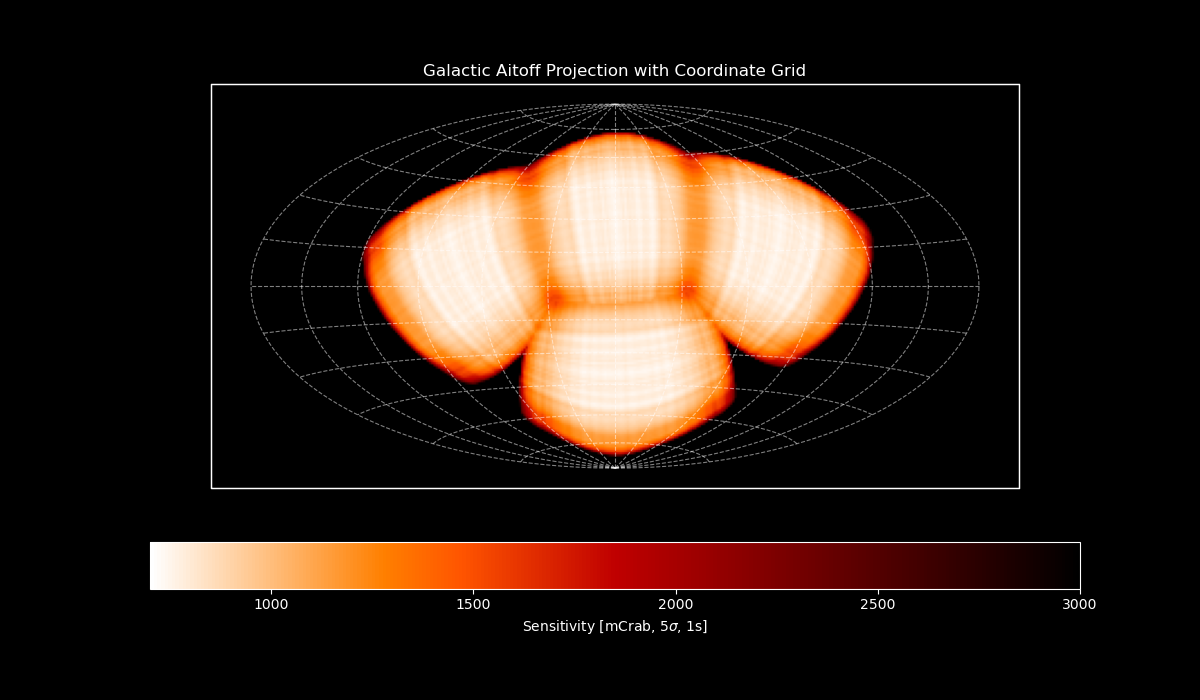

In [26]:
plt.style.use('dark_background')
#removing 0s and forcing them to 10000
composed_image[composed_image==0] = 10000
#plot_galactic_aitoff_with_grid(composed_image, wcs_out)
plot_galactic_aitoff_with_grid(composed_image, w_sky)


In [11]:
from astropy.coordinates import angular_separation

def get_pixel_area_map(wcs, shape):
    """
    Calculates the solid angle (in sq. degrees) for every pixel in the image.
    Uses the local linear approximation (separation between adjacent pixels).
    """
    ny, nx = shape
    
    # 1. Create a grid of pixel coordinates
    # We create a grid for the 'center' of every pixel
    y_idx, x_idx = np.mgrid[0:ny, 0:nx]
    
    # 2. Convert pixel coordinates to World Coordinates (RA/Dec in degrees)
    # pixel_to_world_values is faster than creating SkyCoord objects
    lon, lat = wcs.pixel_to_world_values(x_idx, y_idx)
    
    # Convert to radians for angular_separation math
    lon_rad = np.radians(lon)
    lat_rad = np.radians(lat)
    
    # 3. Calculate the angular size of each pixel
    # We calculate the distance to the "right" neighbor (dx) and "upper" neighbor (dy)
    
    # Separation along X axis (between pixel i,j and i,j+1)
    # We compute this for the first nx-1 columns
    dx = angular_separation(lon_rad[:, :-1], lat_rad[:, :-1], 
                            lon_rad[:, 1:], lat_rad[:, 1:])
    
    # Separation along Y axis (between pixel i,j and i+1,j)
    # We compute this for the first ny-1 rows
    dy = angular_separation(lon_rad[:-1, :], lat_rad[:-1, :], 
                            lon_rad[1:, :], lat_rad[1:, :])
    
    # 4. Compute Area (dx * dy)
    # Note: dx is (ny, nx-1) and dy is (ny-1, nx). 
    # We slice them to matching shapes (ny-1, nx-1)
    area_steradians = dx[:-1, :] * dy[:, :-1]
    
    # Convert Steradians to Square Degrees
    area_sq_deg = area_steradians * (180 / np.pi)**2
    
    # 5. Handle the edge trimming
    # Since we lost 1 row and 1 col due to differencing, we can pad the result 
    # (duplicate the last row/col) to match original image shape.
    full_area_map = np.pad(area_sq_deg, ((0,1), (0,1)), mode='edge')
    
    return full_area_map

In [12]:
area_map = get_pixel_area_map(w_sky, composed_image.shape)
total_area = np.sum(area_map)
x_lim = 1500.0 #mCrab
mask = (composed_image < x_lim) & ~np.isnan(composed_image)
sensitive_area = np.sum(area_map[mask])
print(sensitive_area/total_area)

0.48620788325186703
